In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torchvision.io import read_image
import torchvision.transforms as transforms
import torch.utils.data as data

import glob
import os

import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 

import math

# Utils

In [2]:
#Evaluation
class DetectionMetric:
    def box_iou(self, box1, box2, xyxy=True, CIoU=False):
        """
        Intersection Over Union
        Args:
            box1 (tensor)
            box2 (tensor)
            xyxy (bool)
            CIoU (bool)
        Returns:
            iou 
        """
        if xyxy:
            box1_x1 = box1[..., 0:1]
            box1_y1 = box1[..., 1:2]
            box1_x2 = box1[..., 2:3]
            box1_y2 = box1[..., 3:4]
            box2_x1 = box2[..., 0:1]
            box2_y1 = box2[..., 1:2]
            box2_x2 = box2[..., 2:3]
            box2_y2 = box2[..., 3:4]
        else:
            box1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
            box1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
            box1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
            box1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2
            box2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
            box2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
            box2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
            box2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2
            
        x1 = torch.max(box1_x1, box2_x1)
        y1 = torch.max(box1_y1, box2_y1)
        x2 = torch.min(box1_x2, box2_x2)
        y2 = torch.min(box1_y2, box2_y2)

        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
        box1_width, box1_height = box1_x2 - box1_x1, box1_y2 - box1_y1
        box2_width, box2_height = box2_x2 - box2_x1, box2_y2 - box2_y1
        union = box1_width * box1_height + box2_width * box2_height - intersection
        iou = intersection / (union + 1e-6)

        if CIoU:
            '''
            Complete-IOU Loss Implementation
            Author: William Stevens
            - Inspired by the official paper on Distance-IOU Loss (https://arxiv.org/pdf/1911.08287.pdf)
            - Combines multiple factors for bounding box regression: IOU loss, distance loss, and aspect ratio loss.
            - This results in much faster convergence than traditional IOU and generalized-IOU loss functions.
            Args:
                - preds: prediction tensor containing confidence scores for each class.
                - target: ground truth containing correct class labels.
            '''
            convex_width = torch.max(box1_x2, box2_x2) - torch.min(box1_x1, box2_x1)
            convex_height = torch.max(box1_y2, box2_y2) - torch.min(box1_y1, box2_y1)
            convex_diag_sq = convex_width**2 + convex_height**2
            center_dist_sq = (box2_x1 + box2_x2 - box1_x1 - box1_x2)**2 + (box2_y1 + box2_y2 - box1_y1 - box1_y2)**2
            dist_penalty = center_dist_sq / convex_diag_sq

            v = (4 / math.pi**2) * torch.pow(torch.atan(box2_width / box2_height) - torch.atan(box1_width / box1_height), 2)
            with torch.no_grad():
                alpha = v / ((1 + 1e-6) - iou + v)
            aspect_ratio_penalty = alpha * v
            
            return iou - dist_penalty + aspect_ratio_penalty
        
        return iou

In [3]:
#Utils
class DetectionUtils:
    def xyxy_to_xywh(self, bbox):
        '''
        Converts bounding box of format x1, y1, x2, y2 to x, y, w, h
        Args:
            bbox: bounding box with format x1, y1, x2, y2
        Return:
            bbox_: bounding box with format x, y, w, h if norm is False else the coordinates are normalized to the height and width of the image
        '''
        bbox_ = bbox.clone() if isinstance(bbox, torch.Tensor) else np.copy(bbox)
        bbox_[0] = (bbox[0] + bbox[2]) / 2
        bbox_[1] = (bbox[1] + bbox[3]) / 2
        bbox_[2] = bbox[2] - bbox[0]
        bbox_[3] = bbox[3] - bbox[1]

        return bbox_

    def xywh_to_xyxy(self, bbox):
        '''
        Converts bounding box of format x, y, w, h to x1, y1, x2, y2
        Args:
            bbox: bounding box with format x, y, w, h
        Return:
            bbox_: bounding box with format x1, y2, x2, y2
        '''
        bbox_ = bbox.clone() if isinstance(bbox, torch.Tensor) else np.copy(bbox)
        bbox_[:, 0] = (bbox[:, 0] - bbox[:, 2] / 2) 
        bbox_[:, 1] = (bbox[:, 1] - bbox[:, 3] / 2)
        bbox_[:, 2] = (bbox[:, 0] + bbox[:, 2] / 2) 
        bbox_[:, 3] = (bbox[:, 1] + bbox[:, 3] / 2)

        return bbox_


class SegmentationUtils:
    def __init__(self):
        pass

# Model

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        '''
        Standard convolution block:
            1. Convolution
            2. Batch Normalization
            3. Activation Function (LeakyReLU)

        Args:
            in_channels (int): number of channels in input image or feature map
            out_channels (int): number of channels produced by the convolution
            kernel_size (int): size of convolving kernel
            stride (int): stride of convolution
            padding (int): padding of input
        '''
        super().__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.LeakyReLU(0.1)

    def forward(self, x):
        '''
        Forward pass: Convolution -> Batchnorm -> LeakReLU
        '''
        return self.act(self.bn(self.conv(x)))

class ResBlock(nn.Module):
    def __init__(self, conv1x1, conv3x3):
        '''
        Initialize ResBlock object
        - Obtain parent class's information, functions, and fields using super().__init__() of nn.Module
        - Define variables and function calls using the object initialization parameters
        Args:
            conv1x1 (tuple): 
            conv3x3 (tuple): 
        '''
        super().__init__()

        in_ch1, out_ch1, filter1, padding1, s1 = conv1x1
        in_ch2, out_ch2, filter2, padding2, s2 = conv3x3
        self.firstConvBlock = ConvBlock(in_ch1, out_ch1, filter1, s1, padding1)
        self.secondConvBlock = ConvBlock(in_ch2, out_ch2, filter2, s2, padding2)

    def forward(self, x):
        '''
        Override of forward pass inherited from parent class nn.Module
        - Use function calls defined in object initialization to carry out desired forward pass
        '''
        input = x
        x = self.firstConvBlock(x)
        x = self.secondConvBlock(x)
        return x + input

class Darknet53(nn.Module):
    '''
    Darknet-53 Backbone
    '''
    def __init__(self):
        super().__init__()

        self.config = {
            'c1': [(3, 32, 3, 1, 1),
                   (32, 64, 3, 1, 2),
                   [(64, 32, 1, 0, 1), (32, 64, 3, 1, 1), 1]],
            'c2': [(64, 128, 3, 1, 2),
                   [(128, 64, 1, 0, 1), (64, 128, 3, 1, 1), 2]],
            'c3': [(128, 256, 3, 1, 2),
                   [(256, 128, 1, 0, 1), (128, 256, 3, 1, 1), 8]],
            'c4': [(256, 512, 3, 1, 2),
                   [(512, 256, 1, 0, 1), (256, 512, 3, 1, 1), 8]],
            'c5': [(512, 1024, 3, 1, 2),
                   [(1024, 512, 1, 0, 1), (512, 1024, 3, 1, 1), 4]],
        }

        self.c1 = self._build_model(self.config['c1'])
        self.c2 = self._build_model(self.config['c2'])
        self.c3 = self._build_model(self.config['c3'])
        self.c4 = self._build_model(self.config['c4'])
        self.c5 = self._build_model(self.config['c5'])
        
        #self.stages = {key: self._build_model(conf) for key, conf in self.config.items()}

    def _build_model(self, conf):
        '''
        Builds nn.Sequential sequence of the model's layers
        - Using the config defined in the constructor, loop through the instructions
        - When instruction is a tuple, execute a single convolutional layer
        - When instruction is a list, execute a certain number of residual blocks (indicated in list)
        - Use information inside the tuple or list to determine the input channels, output channels,
        filter size, padding, and stride
        '''
        layers = []
        for x in conf:
            if type(x) == tuple:
                '''
                Execute convolutional layer from tuple as: (in_channels, out_channels, filter size, padding, stride)
                - Extract individual variables from tuple, then pass them into new ConvLayer object as parameters
                - Append this ConvLayer object to the layers list
                '''
                in_ch, out_ch, f_size, pad, s = x
                layers += [ConvBlock(in_ch, out_ch, f_size, s, pad)]
            elif type(x) == list:
                '''
                Execute a number (repeats) of residual blocks from list as: [ConvLayer tuple, ConvLayer tuple, repeats]
                - Where ConvLayer tuples are the convolutional layers to be passed into each residual block
                - Extract individual variables from list, then pass them into new ResBlock object as parameters
                - Use a for loop executing "repeats" number of times to append a number of residual blocks to the sequence
                - For each residual block, use the conv1x1 and conv3x3 tuples to pass into a new ResBlock object and add to the list
                '''
                conv1x1, conv3x3, repeats = x[0], x[1], x[2]
                for _ in range(repeats):
                    layers += [ResBlock(conv1x1, conv3x3)]
        
        return nn.Sequential(*layers)
    
    def forward(self, x):

        c1 = self.c1(x)
        c2 = self.c2(c1)
        c3 = self.c3(c2)
        c4 = self.c4(c3)
        c5 = self.c5(c4)

        return c1, c2, c3, c4, c5

class SPP(nn.Module):
    '''
    Spatial Pyramid Pooling Block
    '''
    def __init__(self, in_ch, out_ch, k=(5, 9, 13)):
        super().__init__()
        ch = in_ch // 2
        self.conv1 = ConvBlock(in_ch, ch, kernel_size=1, stride=1, padding=0)
        self.conv2 = ConvBlock(4 * ch, out_ch, kernel_size=3, stride=1, padding=1)
        #self.conv3 = ConvBlock(in_ch, ch, kernel_size=1, stride=1, padding=0)
        self.maxpools = nn.ModuleList([nn.MaxPool2d(kernel_size=k_, stride=1, padding=k_//2) for k_ in k])
        
    def forward(self, x):
        x = self.conv1(x)
        #x = self.conv2(x)
        #x = self.conv3(x)
        return self.conv2(torch.cat([x] + [maxpool(x) for maxpool in self.maxpools], 1))


class FPN(nn.Module):
    '''
    Feature Pyramid Network
    '''
    def __init__(self):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')

        #P5
        self.conv_c5 = ConvBlock(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0)

        #P4
        self.conv_c4 = ConvBlock(in_channels=512, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv_m4 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1) 
        
        #P3
        self.conv_c3 = ConvBlock(in_channels=256, out_channels=256, kernel_size=1, stride=1, padding=0)
        self.conv_m3 = ConvBlock(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

    def forward(self, c3, c4, c5):

        p5 = self.conv_c5(c5)
        m4 = self.upsample(p5) + self.conv_c4(c4)
        p4 = self.conv_m4(m4)

        m3 = self.upsample(p4) + self.conv_c3(c3)
        p3 = self.conv_m3(m3)
        
        return p5, p4, p3


class YoloHead(nn.Module):
    '''
    Detection Head
    '''
    def __init__(self, n_classes, n_anchors):
        super().__init__()
        
        self.n_anchors = n_anchors
        self.n_classes = n_classes
        self.n_out = 5 + n_classes

        self.conv = ConvBlock(in_channels=256, out_channels=n_anchors*self.n_out, kernel_size=1, stride=1, padding=0)

    def forward(self, p5, p4, p3):
        '''
        Forward pass
        '''
        bs, _, j5, i5 = p5.shape
        d5 = self.conv(p5).view(bs, self.n_anchors, j5, i5, self.n_out)

        bs, _, j4, i4 = p4.shape
        d4 = self.conv(p4).view(bs, self.n_anchors, j4, i4, self.n_out)

        bs, _, j3, i3 = p3.shape
        d3 = self.conv(p3).view(bs, self.n_anchors, j3, i3, self.n_out)

        return [d5, d4, d3]


class LaneHead(nn.Module):
    '''
    Segmentation Head
    '''
    def __init__(self):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv1 = ConvBlock(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2 = ConvBlock(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = ConvBlock(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = ConvBlock(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv5 = ConvBlock(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv6 = ConvBlock(in_channels=8, out_channels=9, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.upsample(x)
        x = self.conv6(x)

        return x

class DrivableHead(nn.Module):
    '''
    Segmentation Head
    '''
    def __init__(self):
        super().__init__()

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv1 = ConvBlock(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv2 = ConvBlock(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = ConvBlock(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv4 = ConvBlock(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv5 = ConvBlock(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1)
        self.conv6 = ConvBlock(in_channels=8, out_channels=3, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.upsample(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.upsample(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.upsample(x)
        x = self.conv6(x)

        return x

class YoloMulti(nn.Module):
    '''
    Multi-Task network based on YOLO framework
    '''
    def __init__(self, n_classes=13, n_anchors=3):
        super().__init__()
        #Backbone   
        self.darknet53 = Darknet53()
        #Neck
        self.spp = SPP(in_ch=1024, out_ch=512)
        self.fpn = FPN()
        # #Heads
        self.detect_head = YoloHead(n_classes=n_classes, n_anchors=n_anchors)
        self.lane_head = LaneHead()
        self.drive_head = DrivableHead()

    def forward(self, x):
        c1, c2, c3, c4, c5 = self.darknet53(x)
        spp = self.spp(c5)
        p5, p4, p3 = self.fpn(c3, c4, spp)
        lane = self.lane_head(p3)
        drivable = self.drive_head(p3)
        det = self.detect_head(p5, p4, p3)

        return det, lane, drivable

In [6]:
# Test Model
x = torch.randn(2, 3, 416, 416)
model = YoloMulti()
det, lane, drive = model(x)
print(f'detection scale 1 {det[0].shape}')
print(f'detection scale 2 {det[1].shape}')
print(f'detection scale 3 {det[2].shape}')
print(f'lane {lane.shape}')
print(f'drivable area {drive.shape}')

detection scale 1 torch.Size([2, 3, 13, 13, 18])
detection scale 2 torch.Size([2, 3, 26, 26, 18])
detection scale 3 torch.Size([2, 3, 52, 52, 18])
lane torch.Size([2, 9, 416, 416])
drivable area torch.Size([2, 3, 416, 416])


# Loss Function

In [103]:
ANCHORS = [[(3,9),(5,11),(4,20)], [(7,18),(6,39),(12,31)], [(19,50),(38,81),(68,157)]]

class MultiLoss(nn.Module):
    '''
    Multi Task Loss Function
        - Acts entirely as just a combination of the two losses for the two task we are doing
    '''
    def __init__(self, alpha_det, alpha_lane):
        self.det_loss = DetectionLoss()
        self.lane_loss = SegmentationLoss()
        self.alpha_det = alpha_det
        self.alpha_lane = alpha_lane

    def forward(self, dets, lanes, det_targets, lane_targets):
        det_loss = self.det_loss(dets, det_targets)    
        lane_loss = self.lane_loss(lanes, lane_targets)

        return self.alpha_det * det_loss + self.alpha_lane * lane_loss


class DetectionLoss(nn.Module):
    def __init__(self, n_classes=13, alpha_class=1., alpha_box=1., alpha_obj=1., anchors=()):
        super().__init__()
        self.metric = DetectionMetric()

        self.C = n_classes
        self.alpha_class = alpha_class
        self.alpha_box = alpha_box
        self.alpha_obj = alpha_obj
        self.anchors = ANCHORS

    def forward(self, preds, targets):
        '''
        Forward pass of Detection Loss
        Args:
            preds (tensor): [det_head1, det_head2, det_head3]
                - each det_head is a detection from the different scales where we are detection bbox
                - det_head shape: (batch_size, n_anchors, scale, scale, num_classes + 5)
            target (tensor): Groundtruth, size : (batch_size, n_anchors, scale, scale, n_classes + 5)
        Returns:
            loss (tensor): loss value
        '''
        ciou_loss = 0
        for i, pred in enumerate(preds):
            target = targets[i].to(pred.device)
            Iobj = target[..., self.C] == 1
            Inoobj = target[..., self.C] == 0
 
            batch_size, n_anchors, gy, gx, n_outputs = pred.shape
            gridy, gridx = torch.meshgrid([torch.arange(gy), torch.arange(gx)], indexing='ij')
            anchor = torch.tensor(self.anchors[i]).view(1, 3, 1, 1, 2).to(pred.device)

            target[..., self.C+3:self.C+5] = torch.log(1e-6 + target[..., self.C+3:self.C+5] / anchor)

            pred[..., self.C+1:self.C+3] = pred[..., self.C+1:self.C+3].sigmoid()
            #pred[..., self.C+3:self.C+5] = pred[..., self.C+3:self.C+5].exp() * anchor

            iou = self.metric.box_iou(pred[..., self.C+1:self.C+5][Iobj], target[..., self.C+1:self.C+5][Iobj], xyxy=False, CIoU=True).mean()
            ciou_loss += 1 - iou

            #print(f'prediction: {pred[..., self.C+1:self.C+5][Iobj]}')
            #print(f' target: {target[..., self.C+1:self.C+5][Iobj]}')

            obj_loss = self._focal_loss(pred[..., self.C:self.C+1][Iobj], target[..., self.C:self.C+1][Iobj])
            noobj_loss = self._focal_loss(pred[..., self.C:self.C+1][Inoobj], target[..., self.C:self.C+1][Inoobj])

            class_loss = self._focal_loss(pred[..., :self.C][Iobj], target[..., :self.C][Iobj])

        return self.alpha_box * ciou_loss + self.alpha_class * class_loss + self.alpha_obj * (obj_loss + noobj_loss)
    
    def _focal_loss(self, preds, targets, alpha=0.25, gamma=2):
        '''
        Focal Loss Implementation
        Author: William Stevens
        - Inspired by the official paper on Focal Loss (https://arxiv.org/abs/1708.02002)
        - Enhancement to cross entropy loss which improves classification accuracy casued by class imbalances.
        Args:
            - preds (tensor): prediction tensor containing confidence scores for each class.
            - target (tensor): ground truth containing correct class labels.
            - alpha (tensor): class weights to represent the class imbalance.
            - gamma (int): Focal term. Constant, tunable exponent applied to the modulating factor which amplifies
            loss emphasis on difficult learning tasks that result in misclassification.
        '''
        p = torch.sigmoid(preds)
        ce_loss = F.binary_cross_entropy_with_logits(preds, targets, reduction='mean')
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** gamma)

        if alpha >= 0:
            alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
            loss *= alpha_t 

        return loss.mean() 

class SegmentationLoss(nn.Module):
    '''
    Segmentation Loss Function:
        1. Dice Binary Cross Entropy Loss
        2. IOU Loss 
            - only used for lane due to the thiness of the lane lines
    Author: Daniyaal Rasheed
    Args:
        - preds (tensor): prediction tensor containing probaility of whether a pixel is a type of lane or not
        - target (tensor): ground truth containing correct classification.
    Returns:
        - IOU loss (scalar): Summation of IOU for every lane in the batch
    '''
    def __init__(self):
        super().__init__()
        self.epsilon = 1e-6

    def _focal_loss(self, pred, target):
        num_classes = pred.size(1)
        target = target.squeeze(dim=1)
        loss = 0

        for cls in range(num_classes):
            targetClass = target[:, cls, ...]
            predClass = pred[:, cls, ...]

            logpt = F.binary_cross_entropy_with_logits(predClass, targetClass, reduction='none')
            pt = torch.exp(-logpt)
            focal = (1 - pt).pow(2)

            classLoss = focal * logpt
            loss += classLoss.mean()
        
        return loss

    # def _dice_loss(self, pred, target):
    #     batchSize, numClasses = pred.size(0), pred.size(1)
    #     target = target.view(batchSize, numClasses, -1)
    #     pred = pred.view(batchSize, numClasses, -1)

    #     target = F.one_hot(target.long(), numClasses).permute(0, 2, 1)
    
    #     intersection = torch.sum(pred * target, dim=(0,2))
    #     cardinality = torch.sum(pred + target, dim=(0,2))

    #     diceScore = (2 * intersection) / cardinality.clamp(1e-6)

    #     loss = 1 - diceScore
    #     mask = target.sum((0,2)) > 0
    #     loss * mask.to(loss.dtype)

    #     return loss.mean()

    def forward(self, pred, target):
        focalLoss = self._focal_loss(pred, target)
        #diceLoss = self._dice_loss(pred, target)

        return focalLoss# + diceLoss

# Data Loader

In [8]:
import glob
import os

import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2 

import torch
import torch.utils.data as data
from torchvision.io import read_image

from utils import DetectionUtils

ANCHORS = [[(3,9),(5,11),(4,20)], [(7,18),(6,39),(12,31)], [(19,50),(38,81),(68,157)]]

class BDD100k(data.DataLoader):
    '''
    Data Loader for BDD100k Dataset
        - Object Bounding Box
        - Lane Mask
        - Drivable Area Mask
    '''

    def __init__(self, root, train=True, transform=None, S=[(12, 20), (24, 40), (48, 80)], anchors=()):
        self.root = root 
        self.train = train
        self.transform = transform
        self.utils = DetectionUtils()

        self.detect = pd.read_json(self.root + 'labels/det20/det_train.json') if train else pd.read_json(self.root + 'labels/det20/det_val.json')
        self.detect.dropna(axis=0, subset=['labels'], inplace=True)

        self.class_dict = {
            'pedestrian' : 1,
            'rider' : 2,
            'car' : 3,
            'truck' : 4, 
            'bus' : 5, 
            'train' : 6, 
            'motorcycle' : 7,
            'bicycle' : 8,
            'traffic light' : 9,
            'traffic sign' : 10,
            'other vehicle': 11,
            'trailer': 12,
            'other person': 13,
        }
        self.S = S
        self.C = len(self.class_dict)

        assert len(anchors) == len(S), "Anchors and scale prediction not matching"

        self.anchors = torch.tensor(anchors[0] + anchors[1] + anchors[2])
        self.n_anchors = self.anchors.shape[0]
        self.n_anchors_scale = self.n_anchors // 3
        self.ignore_iou_thresh = 0.5
        self.utils = DetectionUtils()
        
    def __len__(self):
        return len(self.detect.index)

    def _iou_anchors(self, box, anchor):
        '''
        IOU for anchors boxes
        '''
        intersection = torch.min(box[...,0], anchor[...,0]) * torch.min(box[...,1], anchor[...,1])
        union = (box[...,0] * box[...,1] + anchor[...,0] * anchor[...,1]) - intersection

        return intersection / union
  
    def __getitem__(self, index):
        target = self.detect.iloc[index]

        img_path = self.root + 'images/100k/train/' if self.train else self.root + 'images/100k/val/'
        img = read_image(img_path + target['name']) 
        img = img.type(torch.float32)
        _, height, width = img.shape

        if self.transform:
            img = self.transform(img)
        #--------------------------------------------------------------------------------------------------------------------
        #Bounding Boxes
        label = [torch.zeros(3, Sx, Sy, self.C + 5) for Sx, Sy in self.S]   

        annotations = target['labels']
        bboxes = []
        for obj in annotations:
            obj_class = self.class_dict[obj['category']]
            bbox = list(obj['box2d'].values())
            bbox = self.utils.xyxy_to_xywh(bbox) 
            box_tensor = torch.Tensor(([obj_class] + bbox.tolist()))
            bboxes.append(box_tensor) 

        label = [torch.zeros(self.n_anchors_scale, Sy, Sx, self.C + 5) for Sy, Sx in self.S]

        for bbox in bboxes:
            obj_class, x, y, w, h = bbox.tolist()
            x, w = x / width, w / width
            y, h = y / height, h / height
            obj_class = int(obj_class)
            anchors_iou = self._iou_anchors(bbox[..., 3:5], self.anchors)
            anchor_idx = torch.argmax(anchors_iou, dim=0)
            anchor_exist = [False] * 3

            scale_idx = torch.div(anchor_idx, self.n_anchors_scale, rounding_mode='floor')
            anchor = anchor_idx % self.n_anchors_scale
            Sy, Sx = self.S[scale_idx]
            i, j = int(Sy * y), int(Sx * x)
            exist = label[scale_idx][anchor, i, j, self.C]
            if not exist and not anchor_exist[scale_idx]: 
                label[scale_idx][anchor, i, j, self.C] = 1
                x_, y_ = Sx * x - j, Sy * y - i 
                w_, h_ = Sx * w, Sy * h
                bbox_ = torch.tensor([x_, y_, w_, h_])
                label[scale_idx][anchor, i, j, self.C+1:self.C+5] = bbox_
                label[scale_idx][anchor, i, j, obj_class] = 1
                anchor_exist[scale_idx] = True
            elif not exist and anchors_iou[anchor_idx] > self.ignore_iou_thresh:
                label[scale_idx][anchor, i, j, self.C] = -1

        #--------------------------------------------------------------------------------------------------------------------
        #Lane Mask
        lane_path = self.root + 'labels/lane/masks/train/' if self.train else self.root + 'labels/lane/masks/val/'
        lane_name = os.path.splitext(target['name'])[0] + '.png'
        lane_mask = read_image(lane_path + lane_name)

        #Binary
        lane_mask = self.transform(lane_mask)
        lane_mask[lane_mask == 255.] = 1
        lane_mask = torch.where((lane_mask==0)|(lane_mask==1), lane_mask^1, lane_mask)
        #--------------------------------------------------------------------------------------------------------------------
        # Multi Class
        mask_image = torch.where(lane_mask != 255, 1, 0)
        category_image = torch.bitwise_and(lane_mask, 0x7) * mask_image + (mask_image - 1)
        crosswalk = (category_image == 0).to(torch.float32)
        double_other = (category_image == 1).to(torch.float32)
        double_white = (category_image == 2).to(torch.float32)
        double_yellow = (category_image == 3).to(torch.float32)
        road_curb = (category_image == 4).to(torch.float32)
        single_other = (category_image == 5).to(torch.float32)
        single_white = (category_image == 6).to(torch.float32)
        single_yellow = (category_image == 7).to(torch.float32)
        lane_background = (category_image == 8).to(torch.float32)
        lane = torch.stack([lane_background, single_yellow, single_white, single_other, road_curb,double_yellow, double_white, double_other, crosswalk], dim=0)
        # #--------------------------------------------------------------------------------------------------------------------

        #--------------------------------------------------------------------------------------------------------------------
        #Drivable Area
        drive_path = self.root + 'labels/drivable/masks/train/' if self.train else self.root + 'labels/drivable/masks/val/'
        drive_name = os.path.splitext(target['name'])[0] + '.png'
        drive_mask = read_image(drive_path + drive_name)

        drive_mask = self.transform(drive_mask)[0]
        direct_mask = torch.where(drive_mask == 0, 1, 0)
        alternative_mask = torch.where(drive_mask == 1, 1, 0)
        drive_background = torch.where(drive_mask == 2, 1, 0)
        drivable = torch.stack([drive_background, direct_mask, alternative_mask], dim= 0)
        #--------------------------------------------------------------------------------------------------------------------

        return img / 255., label, lane.to(torch.float32), drivable.to(torch.float32)

In [9]:
#Test Dataloader
transform = transforms.Compose([
transforms.Resize((384, 640), interpolation=transforms.InterpolationMode.NEAREST),
    ])
#Load BDD100k Dataset
train_dataset = BDD100k(root='/home/pumetu/Purdue/LaneDetection/BDD100k/', train=True, transform=transform, anchors=ANCHORS)
val_dataset = BDD100k(root='/home/pumetu/Purdue/LaneDetection/BDD100k/', train=False, transform=transform, anchors=ANCHORS)

train_loader = data.DataLoader(dataset=train_dataset,
                            batch_size=2,
                            num_workers=14, # start at 12, go up to 20 to see which is faster
                            shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, 
                            batch_size=2,
                            num_workers=14,
                            shuffle=False)
imgs, dets, lanes, drives = next(iter(val_loader))

In [10]:
from torchvision.utils import draw_bounding_boxes

def draw_bbox(img, dets):

    def unnorm_bbox(bbox, width, height, i, j, sx, sy):
        '''
        Unormalize the bounding box predictions based on the yolo predictions
        '''
        bbox[:,0] = width * (bbox[:,0] + j) / sx
        bbox[:,1] = height * (bbox[:,1] + i) / sy
        bbox[:,2] = width * (bbox[:,2] / sx)
        bbox[:,3] = height * (bbox[:,3] / sy)

        return bbox

    class_dict = {
        'pedestrian' : 1,
        'rider' : 2,
        'car' : 3,
        'truck' : 4, 
        'bus' : 5, 
        'train' : 6, 
        'motorcycle' : 7,
        'bicycle' : 8,
        'traffic light' : 9,
        'traffic sign' : 10,
        'other vehicle': 11,
        'trailer': 12,
        'other person': 13,
    }
    num_to_class = {i:s for s,i in class_dict.items()}

    utils = DetectionUtils()

    img = img.to(torch.uint8)
    _, height, width = img.shape

    for det in dets:
        scale_pred = det[0]
        sy, sx = scale_pred.shape[1], scale_pred.shape[2]
        for i in range(sy):
            for j in range(sx):
                conf = scale_pred[:, i, j, 13]
                if conf.any() == 1.:
                    scale = torch.argmax(conf)
                    pred = scale_pred[scale]
                    _, pclass = torch.max(pred[..., :13], dim=2)
                    class_pred = num_to_class[pclass[i, j].item()]
                    label = [class_pred]
                    bbox = pred[i, j, 14:19].clone().unsqueeze(0)
                    bbox = unnorm_bbox(bbox, width, height, i ,j, sx, sy)
                    bbox = utils.xywh_to_xyxy(bbox)
                    img = draw_bounding_boxes(img, bbox, width=3, labels=label, colors=(100, 250, 150)) 

    return img

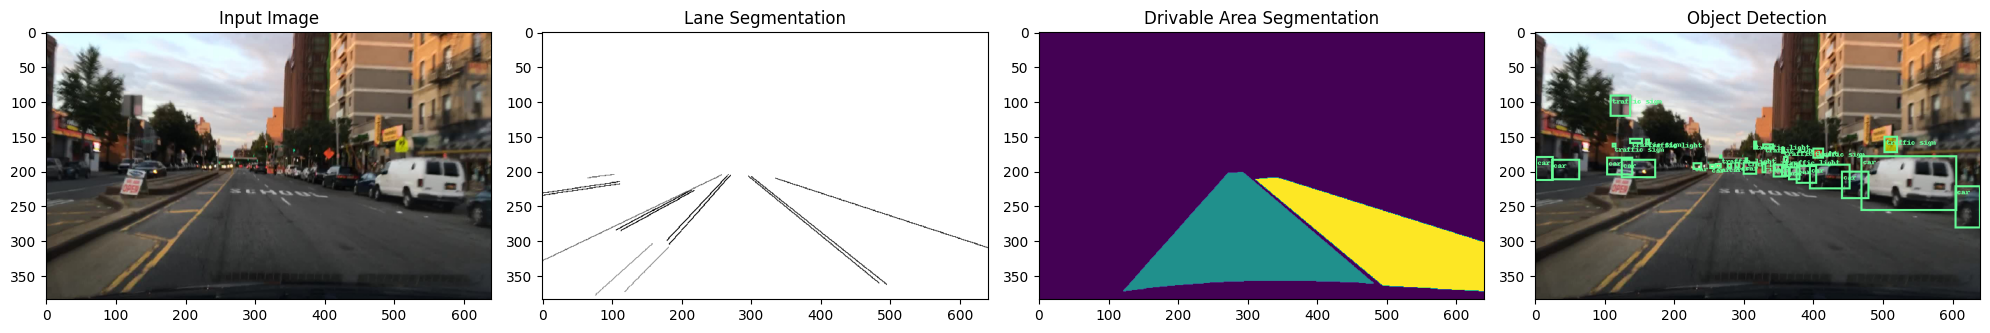

In [11]:
#Multi Class
img, lane, drive = imgs[0] * 255, lanes[0], drives[0]

fig, ax = plt.subplots(1, 4, figsize=(20, 20))
ax[0].imshow(img.permute(1, 2, 0).to(torch.uint8).numpy())
ax[0].set_title('Input Image')

lane_ = torch.argmax(lane, dim=0).permute(1, 2, 0).numpy()
ax[1].imshow(lane_, cmap='gray')
ax[1].set_title('Lane Segmentation')

drive_ = torch.argmax(drive, dim=0).numpy()
ax[2].imshow(drive_)
ax[2].set_title('Drivable Area Segmentation')

bbox_img = draw_bbox(img, dets).permute(1, 2, 0)
ax[3].imshow(bbox_img.numpy())
ax[3].set_title('Object Detection')

plt.tight_layout()

# Training

In [99]:
import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/prototype_lane');

import tqdm

device = torch.device('cuda')
print(f"CUDA device: {torch.cuda.current_device()}")
print(f"CUDA device count: {torch.cuda.device_count()}")

ANCHORS = [[(3,9),(5,11),(4,20)], [(7,18),(6,39),(12,31)], [(19,50),(38,81),(68,157)]]

#Load model
model = YoloMulti().to(device)

#Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = SegmentationLoss()

transform = transforms.Compose([
    transforms.Resize((384, 640), interpolation=transforms.InterpolationMode.NEAREST),
])
#Load BDD100k Dataset
train_dataset = BDD100k(root='/home/pumetu/Purdue/LaneDetection/BDD100k/', train=True, transform=transform, anchors=ANCHORS)
val_dataset = BDD100k(root='/home/pumetu/Purdue/LaneDetection/BDD100k/', train=False, transform=transform, anchors=ANCHORS)

train_loader = data.DataLoader(dataset=train_dataset, 
                            batch_size=4,
                            num_workers=14,
                            shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, 
                            batch_size=4,
                            num_workers=14,
                            shuffle=False)

imgs, det, lane, drivable = next(iter(train_loader))
imgs, lane, drivable = imgs.to(device), lane.to(device), drivable.to(device)

CUDA device: 0
CUDA device count: 1


In [104]:

# Test if small batch overfits correctly
imgs, det, lane, drivable = next(iter(train_loader))
imgs, lane, drivable = imgs.to(device), lane.to(device), drivable.to(device)
model = YoloMulti().to(device)

#Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = SegmentationLoss()

100%|██████████| 10000/10000 [17:32<00:00,  9.50it/s]


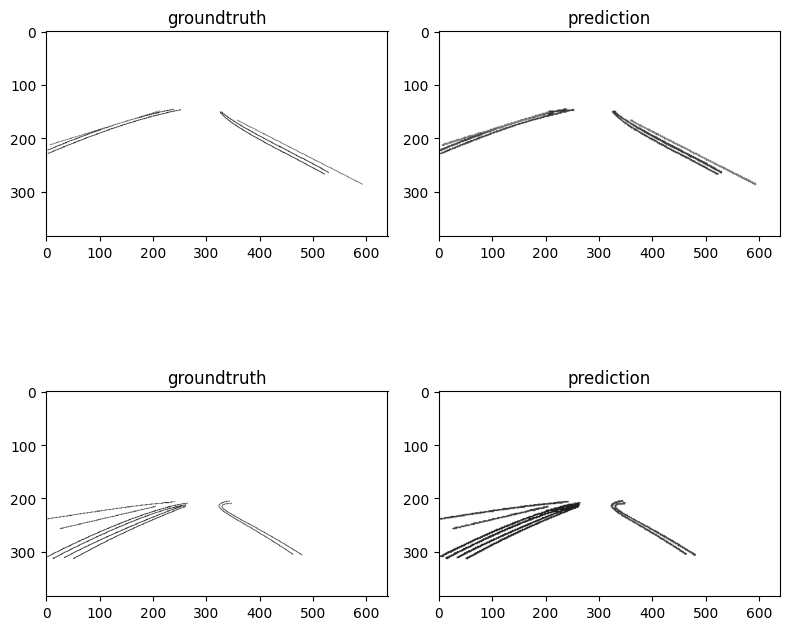

In [105]:
# Test Lanes
for epoch in tqdm.tqdm(range(2000)):
    #--------------------------------------------------------------------------------------
    #Train
    model.train()
    running_loss = 0

    pdet, plane, pdrive = model(imgs)
    lane = lane.squeeze(dim=2)
    loss = loss_fn(plane, lane)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    writer.add_scalar("Loss/train", running_loss, epoch)

fig, ax = plt.subplots(2, 2, figsize=(8,8))

gt1 = torch.argmax(lane[0], dim=0).detach().cpu().numpy()
ax[0,0].imshow(gt1, cmap='gray')
ax[0,0].set_title('groundtruth')
gt2 = torch.argmax(lane[1], dim=0).detach().cpu().numpy()
ax[1,0].imshow(gt2, cmap='gray')
ax[1,0].set_title('groundtruth')

lane1 = torch.argmax(plane[0], dim=0).detach().cpu().numpy()
ax[0,1].imshow(lane1, cmap='gray')
ax[0,1].set_title('prediction')
lane2 = torch.argmax(plane[1], dim=0).detach().cpu().numpy()
ax[1,1].imshow(lane2, cmap='gray')
ax[1,1].set_title('prediction')
plt.tight_layout()

writer.flush()

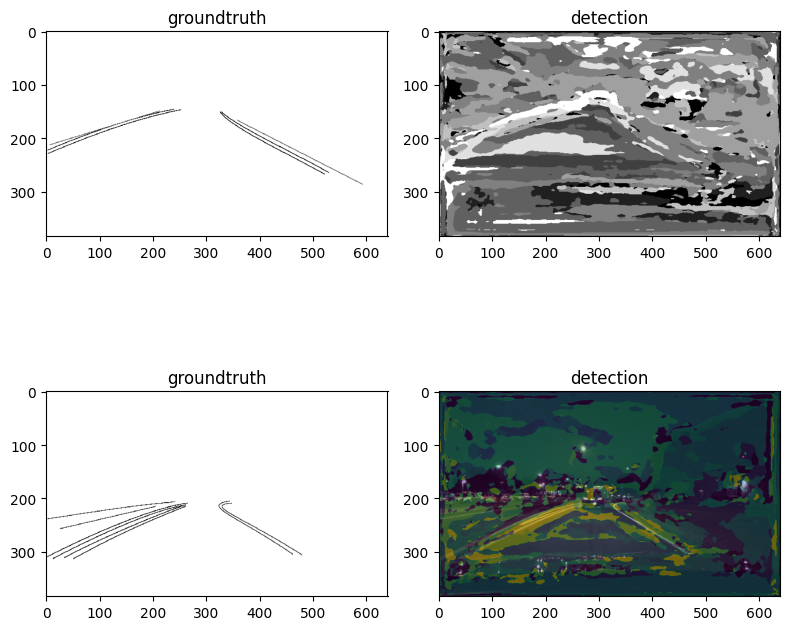

In [117]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))
gt1 = torch.argmax(lane[0], dim=0).detach().cpu().numpy()
ax[0,0].imshow(gt1, cmap='gray')
ax[0,0].set_title('groundtruth')
gt2 = torch.argmax(lane[1], dim=0).detach().cpu().numpy()
ax[1,0].imshow(gt2, cmap='gray')
ax[1,0].set_title('groundtruth')

lane1 = torch.argmax(plane[0], dim=0).detach().cpu().numpy()
ax[0,1].imshow(lane1, cmap='gray')
ax[0,1].set_title('detection')
lane2 = torch.argmax(plane[1], dim=0).detach().cpu().numpy()
ax[1,1].imshow(lane2, alpha=0.75)
ax[1,1].set_title('detection')

plt.tight_layout()

In [108]:
#imgs, det, lane, drivable = next(iter(train_loader))
#mgs, lane, drivable = imgs.to(device), lane.to(device), drivable.to(device)
model = YoloMulti().to(device)

#Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = SegmentationLoss()

100%|██████████| 10000/10000 [16:50<00:00,  9.90it/s]


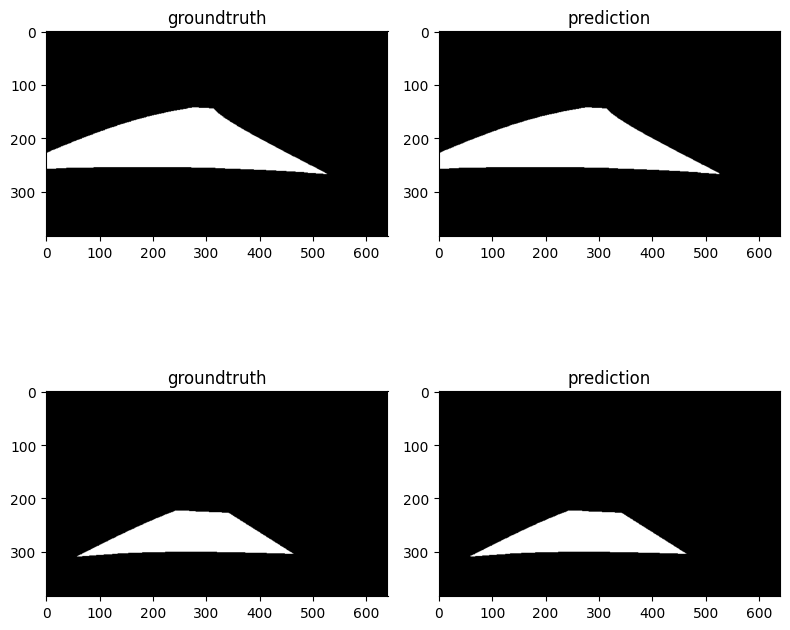

In [110]:
for epoch in tqdm.tqdm(range(10000)):
    #--------------------------------------------------------------------------------------
    #Train
    model.train()
    running_loss = 0

    pdet, plane, pdrivable = model(imgs)
    loss = loss_fn(pdrivable, drivable)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    writer.add_scalar("Loss/train", running_loss, epoch)

fig, ax = plt.subplots(2, 2, figsize=(8,8))

gt1 = torch.argmax(drivable[0], dim=0).detach().cpu().numpy()
ax[0,0].imshow(gt1, cmap='gray')
ax[0,0].set_title('groundtruth')
gt2 = torch.argmax(drivable[1], dim=0).detach().cpu().numpy()
ax[1,0].imshow(gt2, cmap='gray')
ax[1,0].set_title('groundtruth')

lane1 = torch.argmax(pdrivable[0], dim=0).detach().cpu().numpy()
ax[0,1].imshow(lane1, cmap='gray')
ax[0,1].set_title('prediction')
lane2 = torch.argmax(pdrivable[1], dim=0).detach().cpu().numpy()
ax[1,1].imshow(lane2, cmap='gray')
ax[1,1].set_title('prediction')
plt.tight_layout()
writer.flush()

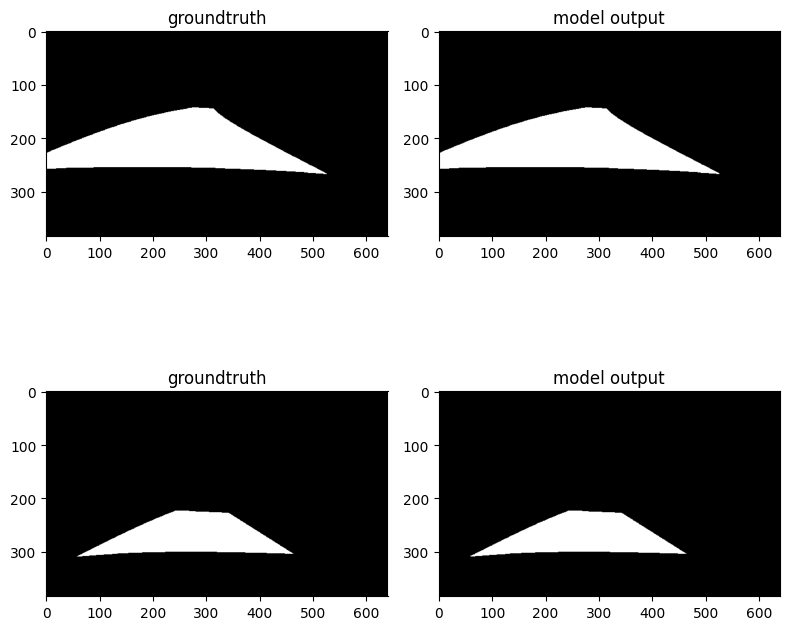

In [113]:
fig, ax = plt.subplots(2, 2, figsize=(8,8))

gt1 = torch.argmax(drivable[0], dim=0).detach().cpu().numpy()
ax[0,0].imshow(gt1, cmap='gray')
ax[0,0].set_title('groundtruth')
gt2 = torch.argmax(drivable[1], dim=0).detach().cpu().numpy()
ax[1,0].imshow(gt2, cmap='gray')
ax[1,0].set_title('groundtruth')

lane1 = torch.argmax(pdrivable[0], dim=0).detach().cpu().numpy()
ax[0,1].imshow(lane1, cmap='gray')
ax[0,1].set_title('model output')
lane2 = torch.argmax(pdrivable[1], dim=0).detach().cpu().numpy()
ax[1,1].imshow(lane2, cmap='gray')
ax[1,1].set_title('model output')
plt.tight_layout()
writer.flush()

In [86]:
imgs, dets, lane, drivable = next(iter(train_loader))
imgs, lane, drivable = imgs.to(device), lane.to(device), drivable.to(device)
model = YoloMulti().to(device)

#Set optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = DetectionLoss()

In [88]:
torch.set_printoptions(profile='default')

for epoch in tqdm.tqdm(range(2000)):
    #--------------------------------------------------------------------------------------
    #Train
    model.train()
    running_loss = 0

    pdet, plane, pdrivable = model(imgs)
    loss = loss_fn(pdet, dets)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
    writer.add_scalar("Loss/train", running_loss, epoch)
    
writer.flush()

100%|██████████| 2000/2000 [03:24<00:00,  9.79it/s]


In [95]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

def nms(bboxes, iou_threshold, conf_threshold):
    bboxes = [box for box in bboxes if box[1] > conf_threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
            or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format='midpoint'
            )
            < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms  

def process_prediction(prediction, img_height, img_width, anchor, C=13):
    batch_size, n_anchors, gy, gx, n_outputs = prediction.shape
    prediction = prediction[0].clone().detach().cpu()
    gridy, gridx = torch.meshgrid([torch.arange(gy), torch.arange(gx)], indexing='ij')
    prediction[..., C+1:C+3] = prediction[..., C+1:C+3].sigmoid()
    prediction[..., C+3:C+5] = prediction[..., C+3:C+5].exp() * anchor

    confidence = prediction[..., C].sigmoid()

    predicted_class = torch.argmax(prediction[..., :C], dim=-1)
    x = (prediction[..., C+1] + gridx) / gx * img_width
    y = (prediction[..., C+2] + gridy) / gy * img_height
    width = prediction[..., C+3] / gx * img_width
    height = prediction[..., C+4] / gy * img_height
    detection = torch.stack((predicted_class, confidence, x, y, width, height), dim=-1).view(batch_size, -1, 6)

    return detection   
    
def get_bboxes(predictions, iou_threshold, conf_threshold):
    batch_size = predictions[0].shape[0]
    for i, prediction in enumerate(predictions):
        anchor = torch.tensor(ANCHORS[i]).view(1, 3, 1, 1, 2)
        detection = process_prediction(prediction, 384, 640, anchor, C=13)
    print(detection.shape)
    nms_b = nms(detection[0], iou_threshold, conf_threshold)

    return nms_b

box = get_bboxes(pdet, 0.5, 0.7)

torch.Size([4, 2880, 6])


/tmp/ipykernel_5931/4115536048.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(chosen_box[2:]),
/tmp/ipykernel_5931/4115536048.py:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(box[2:]),


In [ ]:
box

In [ ]:
utils = DetectionUtils()

fig, ax = plt.subplots(1, 2, figsize=(12,12))
img = (imgs[0] * 255).to(torch.uint8)
for i, b in enumerate(box):
    coord = utils.xywh_to_xyxy(b[2:].unsqueeze(0)).to(torch.uint8)
    img = draw_bounding_boxes(img, coord, width=3, colors=(100, 250, 150)) 
    ax[0].imshow(img.permute(1, 2, 0).detach().cpu().numpy())
    ax[0].set_title('prediction')
    

img = imgs[0].detach().cpu() * 255
bbox_img = draw_bbox(img, dets).permute(1, 2, 0)
ax[1].imshow(bbox_img.numpy())
ax[1].set_title('Groundtruth')